This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Advanced deep learning for computer vision

## Three essential computer vision tasks

## An image segmentation example

In [0]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [2]:
import os

input_dir = "/home/kent/college/data_sets/pets/images/"
target_dir = "/home/kent/college/data_sets/pets/annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

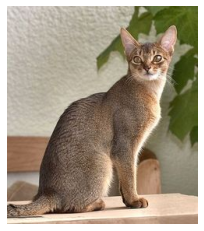

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[34]))

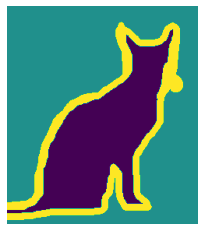

In [9]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[34], color_mode="grayscale"))
display_target(img)

In [10]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

2022-03-10 23:05:27.644436: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-10 23:05:27.646999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kent-5040): /proc/driver/nvidia/version does not exist
2022-03-10 23:05:27.666726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [13]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=25,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/25
100/100 [==============================] - 1315s 13s/step - loss: 6.7904 - val_loss: 0.9377
Epoch 2/25
100/100 [==============================] - 1279s 13s/step - loss: 0.9561 - val_loss: 0.8680
Epoch 3/25
100/100 [==============================] - 1269s 13s/step - loss: 0.8517 - val_loss: 0.9670
Epoch 4/25
100/100 [==============================] - 1263s 13s/step - loss: 0.8002 - val_loss: 0.7307
Epoch 5/25
100/100 [==============================] - 1266s 13s/step - loss: 0.7417 - val_loss: 0.7183
Epoch 6/25
100/100 [==============================] - 1265s 13s/step - loss: 0.6813 - val_loss: 0.6628
Epoch 7/25
100/100 [==============================] - 1266s 13s/step - loss: 0.6401 - val_loss: 0.6225
Epoch 8/25
100/100 [==============================] - 1265s 13s/step - loss: 0.5997 - val_loss: 0.5970
Epoch 9/25
100/100 [==============================] - 1267s 13s/step - loss: 0.5850 - val_loss: 0.5380
Epoch 10/25
100/100 [==============================] - 1270s 13s/step - l

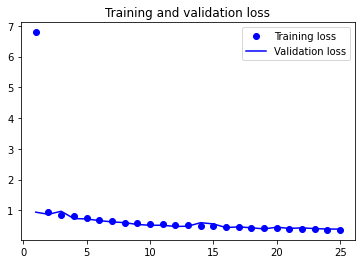

In [14]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

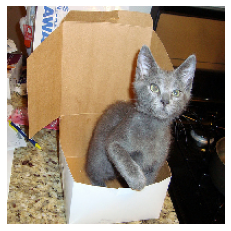

In [24]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
i = 300
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))


In [27]:
test_image.shape

(200, 200, 3)

In [42]:
test_image[0,0,1]

56.0

In [35]:
# red
test_image[..., 0].min()
test_image[..., 0].max()
# green
test_image[..., 1].min()
test_image[..., 1].max()
# blue
test_image[..., 2].min()
test_image[..., 2].max()

255.0

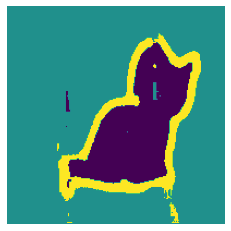

In [25]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

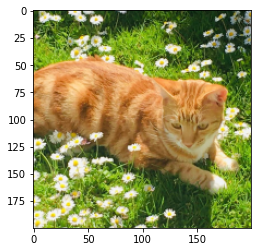

In [37]:
import matplotlib.image as mpimg
cat = mpimg.imread("/home/kent/college/data_sets/scoby/IMG-20210525-WA0008_200.png")
plt.imshow(cat)

In [38]:
cat.shape

(200, 200, 3)

In [44]:
(cat*255)[0:10,0:10,1]

array([[157.,  90.,  63.,  79.,  87.,  76., 165., 169., 188., 163.],
       [ 78.,  90.,  79.,  82.,  80., 147., 202., 188., 201., 184.],
       [ 71.,  78.,  78.,  77.,  71., 142., 181., 180., 179., 188.],
       [ 75.,  70.,  72.,  74.,  56., 139., 189., 157., 169., 178.],
       [ 81.,  62.,  63.,  68.,  49., 113., 196., 168., 146., 186.],
       [ 70.,  58.,  61.,  55.,  58., 119., 168., 174., 207., 196.],
       [ 66.,  57.,  60.,  61.,  63.,  74., 183., 209., 237., 241.],
       [ 66.,  62.,  63.,  77.,  66., 104., 225., 242., 244., 235.],
       [ 58.,  62.,  78.,  79.,  62., 133., 235., 241., 241., 233.],
       [ 53.,  66.,  64.,  52.,  49.,  85., 221., 243., 240., 223.]],
      dtype=float32)

In [45]:
cat = cat*255

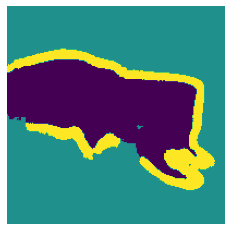

In [46]:
mask = model.predict(np.expand_dims(cat, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

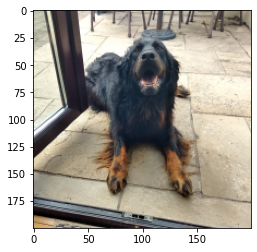

In [47]:
import matplotlib.image as mpimg
scoby = mpimg.imread("/home/kent/college/data_sets/scoby/IMG_20200709_192029_200.png")
plt.imshow(scoby)

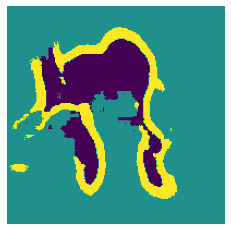

In [48]:
scoby = scoby * 255
mask = model.predict(np.expand_dims(scoby, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)